# Routing

Routing（路由）

当用户的问题“可能有多种处理方式 / 多个知识来源 / 多种回答策略”时，系统要先“判断该走哪条路”，而不是一上来就 RAG。

这个“判断走哪条路”的过程，就叫 Routing（路由）。

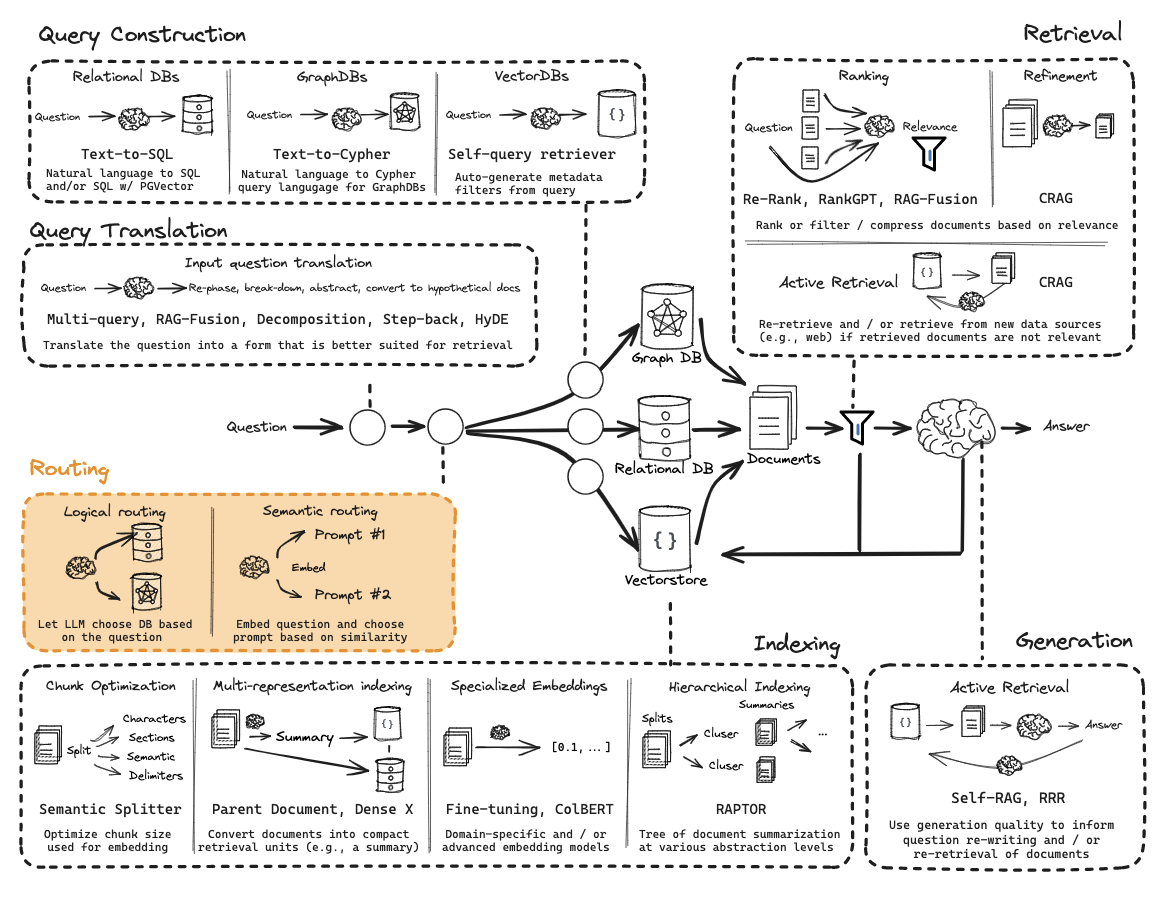

In [2]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
DEEPSEEK_BASE_URL = os.getenv("DEEPSEEK_BASE_URL")

## <mark>1. Logical routing（逻辑路由）</mark>

场景：我们有 3 个知识库
- python_docs
- js_docs
- golang_docs

用户可能问的：
1. “How do I use decorators in Python?”
2. “Why does useEffect run twice?”
3. “How do goroutines work?”

👉 我们不可能把 3 个库混在一起查，必须先选库

什么时候用 Logical Routing？

- 选数据库（Python / JS / Go）
- 选产品线（搜索 / 下单 / 退款）
- 选工具（计算器 / 浏览器 / RAG）
- 选功能模式（聊天 / 总结 / 翻译）

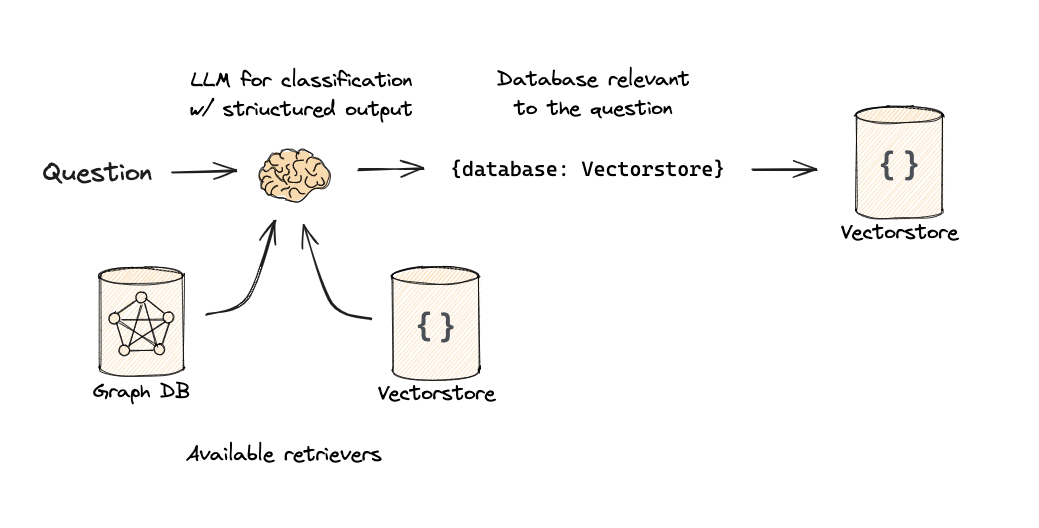

In [4]:
# 以下是代码示例

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek

# 定义数据模型
class RouteQuery(BaseModel):
    """将用户查询路由到最相关的数据源"""

    # description="针对用户提出的问题，选择最适合回答该问题的相关数据源",
    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0
)
structured_llm = llm.with_structured_output(RouteQuery)

# system = """你是一名专业的问题路由专家，负责将用户的问题引导至正确的数据源。

# 请根据用户问题中涉及的编程语言，将其路由到最相关的数据源。"""

system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

router = prompt | structured_llm

In [5]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

In [6]:
result

RouteQuery(datasource='python_docs')

In [7]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

full_chain = router | choose_route

full_chain.invoke({"question": question})

'chain for python_docs'

---

## <mark>2. Semantic routing（语义路由）</mark>

不用 LLM 来“判断类别”，而是用 embedding 判断：

“这个问题和哪个 prompt / 风格 / 专家最像？”

什么时候用 Semantic Routing？

- 专家角色选择（医生 / 律师 / 工程师）
- 回答风格选择
- 学科主题选择（物理 / 数学 / 法律）
- prompt 本身就是“能力模块”

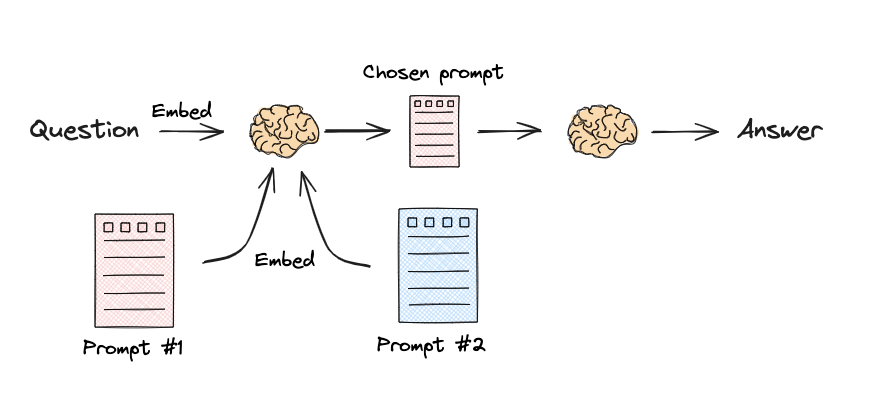

In [3]:
from langchain_community.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI

# 两段提示词
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# 对提示词进行语义嵌入
embeddings = HuggingFaceEmbeddings(
    model_name=r"E:\users\hwy\LLMs-Technology-Projects\models\all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"}
)
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# 把用户问题路由到对应的提示词
def prompt_router(input):
    # 问题嵌入
    query_embedding = embeddings.embed_query(input["query"])
    # 计算相似度
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # 选择提示词
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)

llm = ChatOpenAI(model="gpt-4o-mini")

chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | llm
    | StrOutputParser()
)
print(chain.invoke("What's a black hole?"))

Using PHYSICS
A black hole is an astronomical object with a gravitational pull so strong that nothing, not even light, can escape from it. This occurs when a massive star collapses under its own gravity at the end of its life cycle. The boundary around a black hole beyond which nothing can escape is called the event horizon. Black holes can vary in size, from stellar black holes formed from collapsing stars to supermassive black holes found at the centers of galaxies. The study of black holes helps us understand fundamental aspects of physics, including gravity and the nature of spacetime.
